In [1]:
import h5py
from keras.backend import *
import datetime
from keras.layers import *
from keras.optimizers import Adam
import re
from keras.callbacks import ModelCheckpoint, TensorBoard
import keras.models as KM
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from utils import ChipsDataset
from model import UNET

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

In [4]:
def data_generator(dataset,shuffle=True, batch_size=1):
    """A generator that returns images and corresponding target class ids,
    bounding box deltas, and masks.
    shuffle: If True, shuffles the samples before every epoch
    """
    b = 0  # batch item index
    image_index = -1
    image_ids = np.copy(dataset.image_ids)

    # Keras requires a generator to run indefinitely.
    while True:
#         try:
        # Increment index to pick next image. Shuffle if at the start of an epoch.
        image_index = (image_index + 1) % len(image_ids)
        if shuffle and image_index == 0:
            np.random.shuffle(image_ids)

        image_id = image_ids[image_index]
        image = dataset.load_image(image_id)
        gt_masks = dataset.load_mask(image_id)


        # Init batch arrays
        if b == 0:
            batch_images = np.zeros(
                (batch_size,) + image.shape, dtype=np.float32)
            batch_gt_masks = np.zeros(
                (batch_size, ) + gt_masks.shape, dtype=gt_masks.dtype)


        batch_images[b] = image.astype(np.float32)
        batch_gt_masks[b] = gt_masks
        b += 1

        # Batch full?
        if b >= batch_size:
            inputs = batch_images
            outputs = batch_gt_masks
            yield inputs, outputs

            # start a new batch
            b = 0

In [5]:
train_set = h5py.File('/mnt/sh_flex_storage/malu/venv/multilayer/data/merged_data/data8_data.h5', 'r')
val_set = h5py.File('/mnt/sh_flex_storage/malu/venv/multilayer/data/merged_data/data8_val.h5', 'r')

In [6]:
train_images = train_set['input']
val_images = val_set['input']
train_masks = train_set['output']
val_masks = val_set['output']

In [7]:
del train_set
del val_set
NUM_TRAIN = train_images.shape[0]  # 224*224
NUM_TEST = val_images.shape[0]
print(NUM_TEST, NUM_TRAIN)

1979 16205


In [8]:
# train_dataset = ChipsDataset(train_images, train_masks)
# train_gene = data_generator(train_dataset, batch_size=32)
val_dataset = ChipsDataset(val_images, val_masks)
val_gene = data_generator(val_dataset, batch_size=32)

In [9]:
from model import unet
model = unet()
model_dir = '/mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN/UNet/logs'
model.load_weights(model_dir+'/unet_0001.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [21]:
model.load_weights(model_dir+'/unet_0015.h5')

In [11]:
# results = model.predict_generator(val_gene,32)

In [12]:
# results.shape

In [13]:
image_batch = []
mask_batch = []
for i in range(100):
    image = val_dataset.load_image(i)
    mask = val_dataset.load_mask(i)
    image_batch.append(image)
    mask_batch.append(mask)

/mnt/sh_flex_storage/malu/venv/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [14]:
image_batch = np.array(image_batch)
predict_mask = model.predict(image_batch)

In [15]:
predict_mask = predict_mask.astype(int)

In [16]:
import matplotlib.pyplot as plt

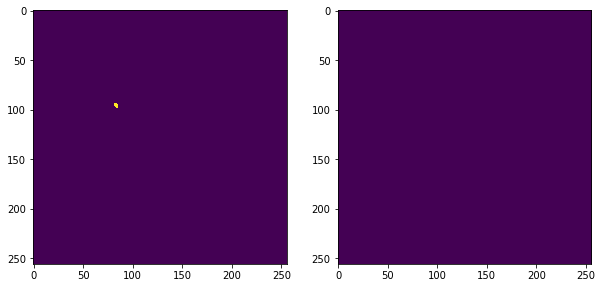

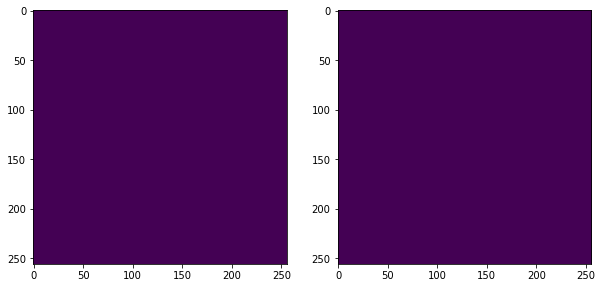

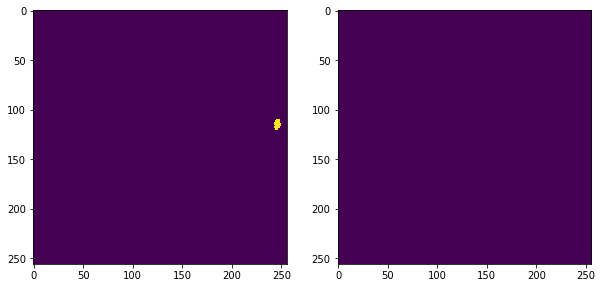

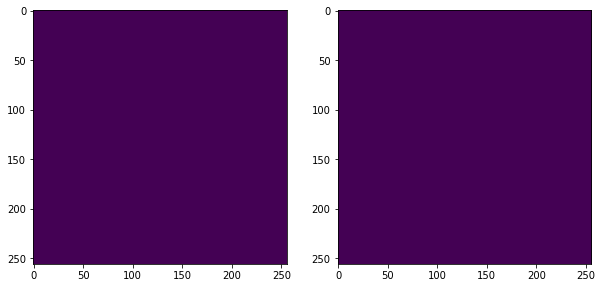

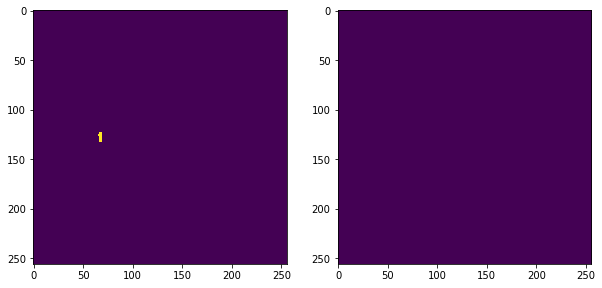

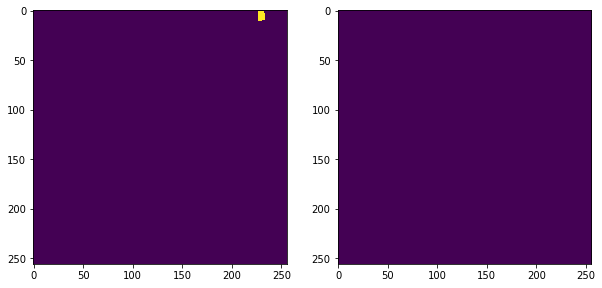

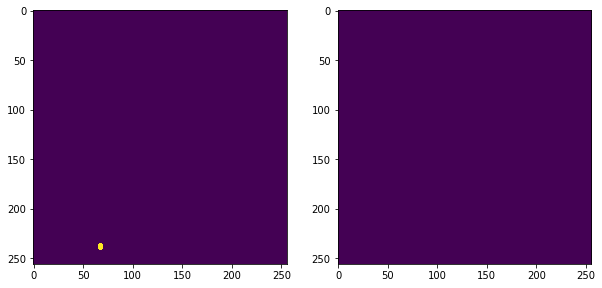

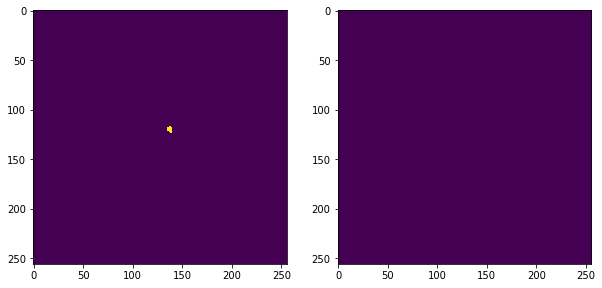

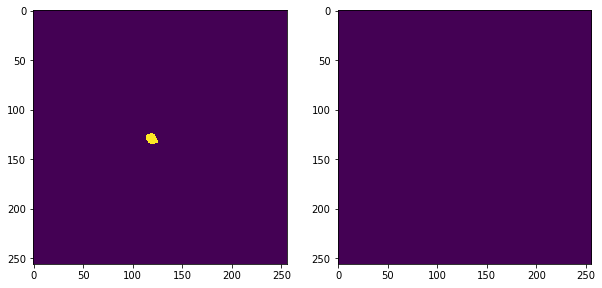

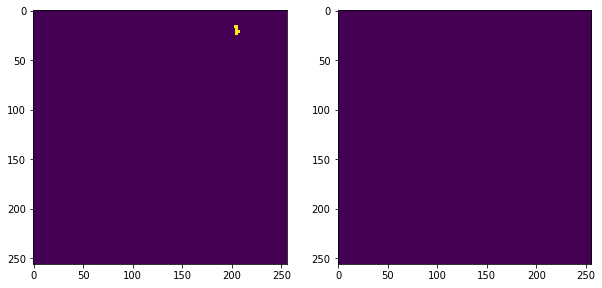

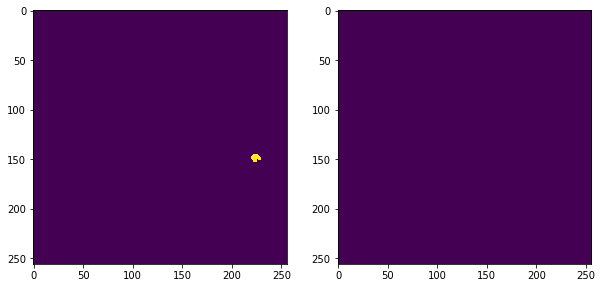

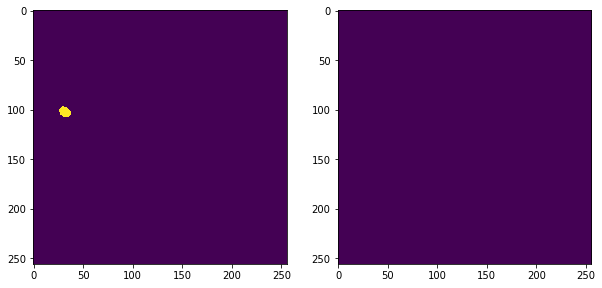

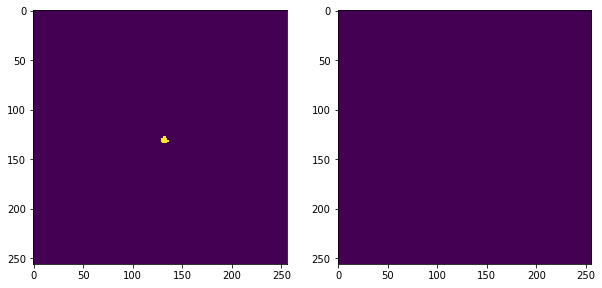

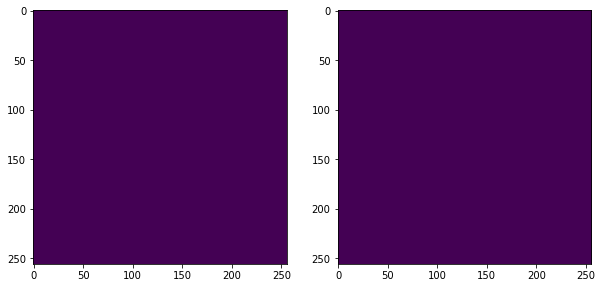

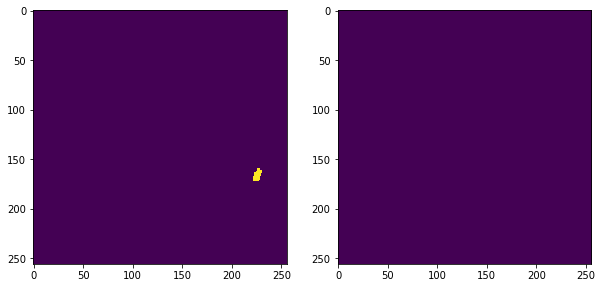

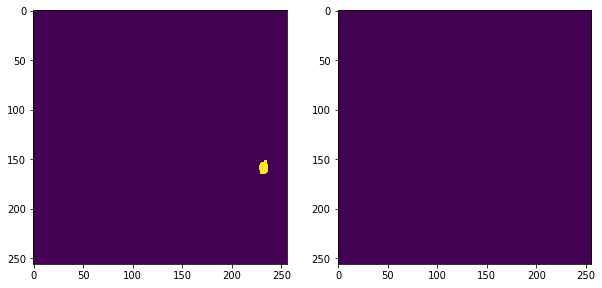

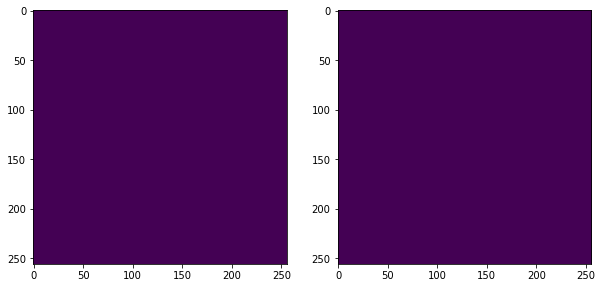

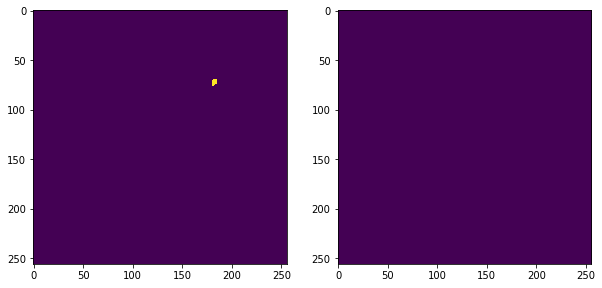

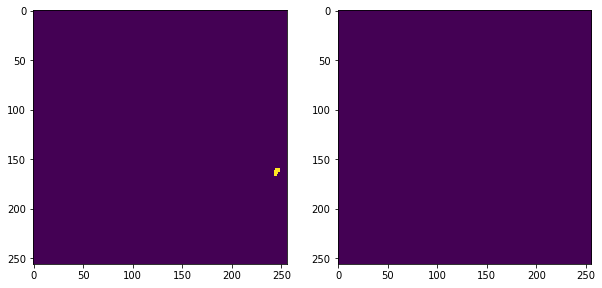

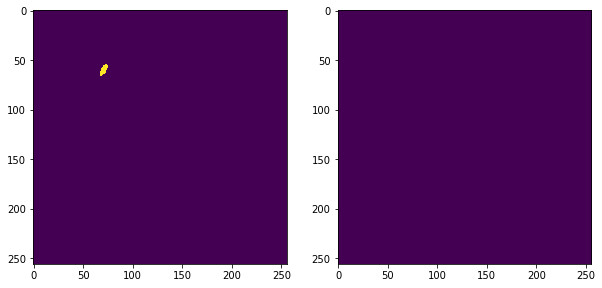

In [22]:
for i in range(20):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(mask_batch[i].reshape(256,256))
    plt.subplot(1,2,2)
    plt.imshow(predict_mask[i].reshape(256,256))
    plt.plot()